# Welcome!

Throughout this tutorial you will:
- Prepare your dataset and compute seismic attributes using Python.
- Load seismic blocks using [segyio](https://github.com/equinor/segyio).
- Create seismic attributes on CPU with Dask.
- Create and manipulate **GPU** accelerated dataframes.
- Train a *k*-means clustering algorithm using **RAPIDS** to perform seismic facies classification on 3D post-stack blocks.

<img src="https://gitlab-master.nvidia.com/jpnavarro/rapids-seismic/-/raw/master/figs/intro.png" width=700 align=center>


# The Problem

**Lithofacies classification** is a crucial step in seismic interpretation. The accurate classification of samples in terms of similarities
leads to a better understanding of the areas of interest. 

Subsurface events contain valuable spatio-temporal information that has scientific and commercial importance, making accurate and fast interpretations a competitive advantage in exploration geophysics. Formerly in seismic analysis, this process consisted of assigning lithofacies manually by human interpreters, following the amplitude responses. This labor-intensive task is being consistently improved by the use of automatic and semi-automatic interpretation tools. 

However, with the increasing quality of acquisition sensors, the size of 3D seismic surveys is facing a significant improvement in terms of
definition, which ultimately leads to longer processing times. Furthermore, the interpretation quality may expressively be improved by adding new perspectives to the original amplitude volume, using, for example, derived attributes such as phase, frequency, and envelope. 

However, in the context of multi-attribute analysis, the computational complexity and requirements proportionally increase.

In this work, we explore the use of GPUs to perform the unsupervised classification (it is not necessary annotated labels) of seismic surveys using the well-established machine learning method **k-means**. We show that the high-performance distributed implementation of the **k-means** algorithm available at the open-source GPU library RAPIDS ([https://rapids.ai/](https://rapids.ai/)) can be used to classify facies of large seismic datasets much faster than a classical parallel CPU implementation (up to 258-fold faster on NVIDIA V100 GPUs), especially for large seismic blocks.

We will walk through facies classification using an unsupervised-learning setting and train **k-means** for different real seismic volumes.

Let's getting started!

# Getting the Dataset

Seismic datasets are usually computationally represented as 3D scalar fields, being each voxel of the volume a 32-bits floating-point (amplitude). The Society of Exploration Geophysics (SEG) made available an [online repository](https://wiki.seg.org/wiki/Open_data) with major surveys from onshore and offshore areas. 

For this tutorial, we will use two marine seismic blocks from the Netherlands and New Zealand offshore regions.

The first dataset is the F3-Netherlands (https://wiki.seg.org/wiki/F3_Netherlands): a 1 GByte time migrated 3D seismic cube. It is available through the Creative Commons 3.0 license. Check the [dGB repository](https://terranubis.com/datainfo/F3-Demo-2020) for a complete reference.

The dataset was modified to adjust the header such that it could be read by the [segyio](https://github.com/equinor/segyio) library:

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D" -O datasets/input/F3.sgy && rm -rf /tmp/cookies.txt

# Data Preparation

Importing Python dependencies.

In [1]:
# Basic imports.
import os
import segyio
import sys
import time
import numpy as np

# Dataframe libraries for attribute computation.
import dask.array as da
import dask.dataframe as ddf

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable

%matplotlib auto

Using matplotlib backend: agg


## Reading Seismic Cubes

Firstly, we will explore the impact of RAPIDS for seismic facies classification on the **F3** seismic block. 

Let's define the input file directory:

In [2]:
input_file = 'datasets/input/F3.sgy'

Pre- and post-stack seismic cubes are often stored following the [SEG-Y standard](https://en.wikipedia.org/wiki/SEG-Y). Notice that most of the files available in SEG Open data repository are released as `.sgy` files.

Equinor made available an easy-to-use SEG-Y file reader with a Python interface. The [**segyio**](https://github.com/equinor/segyio) is a small LGPL licensed C library for easy interaction with SEG-Y and Seismic Unix formatted seismic data, with language bindings for both Python and Matlab.

Let's make a preliminary check on the seismic cubes using the **segyio** library and verify that number of inlines, crosslines, and time slices match the reference we have on SEG repository:

In [3]:
def inspect_seismic_cubes(file_name):
    segy_file = segyio.open(file_name)
    iline_start = int(segy_file.ilines[0])
    iline_end = int(segy_file.ilines[-1])
    iline_offset = int(segy_file.ilines[1] - segy_file.ilines[0])

    xline_start = int(segy_file.xlines[0])
    xline_end = int(segy_file.xlines[-1])
    xline_offset = int(segy_file.xlines[1] - segy_file.xlines[0])

    time_start = int(segy_file.samples[0])
    time_end = int(segy_file.samples[-1])
    time_offset = int(segy_file.samples[1] - segy_file.samples[0])
        
    print("File: {} \n"
          "Inline range: [{}, {}]. Offset: {}\n"
          "Crossline range: [{}, {}]. Offset: {}\n"
          "Time range: [{}, {}]. Offset: {}".format(os.path.basename(file_name),
                                                       iline_start, iline_end, iline_offset, 
                                                       xline_start, xline_end, xline_offset, 
                                                       time_start, time_end, time_offset))
    metadata = {
        'inline': (iline_start, iline_end, iline_offset),
        'crossline': (xline_start, xline_end, xline_offset),
        'time': (time_start, time_end, time_offset)
    }
    
    return metadata

metadata = inspect_seismic_cubes(input_file)

File: F3.sgy 
Inline range: [100, 750]. Offset: 1
Crossline range: [300, 1250]. Offset: 1
Time range: [4, 1848]. Offset: 4


Read the seismic cube as NumPy array. Notice that this may take a while depending on the size of the input volume.

In [4]:
original_cube = np.array(segyio.tools.cube(input_file))
original_cube = np.ascontiguousarray(original_cube, 'float32')

print("Original cube dimension:", original_cube.shape)

Original cube dimension: (651, 951, 462)


In [5]:
# We perform slicing to get a central region on the dataset
# to increase training quality and ensure it will fit GPU memory.
def get_sub_cube(cube, examples_percent):
    assert examples_percent > 0 and examples_percent <= 1.0, "Percent must be in (0,1] range."

    i_num, x_num, t_num = cube.shape

    i_start_idx = int((i_num - (i_num * examples_percent))/2)
    i_end_idx   = int(i_start_idx + (examples_percent * i_num))

    x_start_idx = int((x_num - (x_num * examples_percent))/2)
    x_end_idx   = int(x_start_idx + (examples_percent * x_num))

    t_start_idx = int((t_num - (t_num * examples_percent))/2)
    t_end_idx   = int(t_start_idx + (examples_percent * t_num))

    return cube[i_start_idx:i_end_idx,
                x_start_idx:x_end_idx,
                t_start_idx:t_end_idx]

# Change the following variable if you want to work with bigger or smaller cube fractions.
# The interval for @examples_percent is (0,1]. Defining examples_percent = 0.9
# will pick a central crop on the cube corresponding to 90% of available samples.
examples_percent = 0.9
cube = get_sub_cube(original_cube, examples_percent)

print("Sub-cube dimension:", cube.shape)

Sub-cube dimension: (585, 855, 415)


### Visualizing Seismic Section

For sanity check, let's plot the inline at position 100 (`inline_index=100`). Therefore, we define an auxiliary `plot_slice` procedure, that will also be used thereafter.

Notice that axes are swapped for visualization purposes. Seismic sections are usually visualized using Z axes as depth/time dimension, and X or Y axes being inline or crossline.

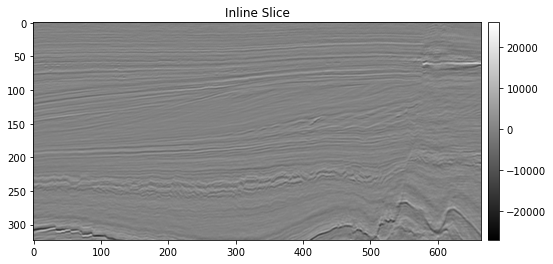

In [6]:
def plot_slice(slice, title=None, cmap='gray', img_scale=0.015, interpolation='bicubic', is_discrete=False):
    img_h = int(slice.shape[0] * img_scale)
    img_w = int(slice.shape[1] * img_scale)    

    plt.figure(figsize=(img_w, img_h))
    if title: plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.1)
    
    if is_discrete:
        cmap = plt.get_cmap(cmap, np.max(slice)-np.min(slice)+1)
        im = ax.imshow(slice, cmap=cmap, interpolation=None, vmin = np.min(slice)-.5, vmax = np.max(slice)+.5)
        plt.colorbar(im, cax=cax, ticks=np.arange(np.min(slice),np.max(slice)+1))
    else:        
        im = ax.imshow(slice, cmap=cmap, interpolation=interpolation)
        plt.colorbar(im, cax=cax);
        
inline_index = 0
plot_slice(np.swapaxes(cube[inline_index,:,:], 0, 1), title='Inline Slice')

## Feature Vectors & Seismic Attributes

Instead of directly classify the amplitude examples, we will combine different seismic attributes extracted from the cube to form *classifiable feature vectors*.

But what is a seismic attribute?


A **seismic attribute** is a measurement over seismic domains that quantitatively or qualitatively enhances dataset features of interest. Useful attributes are either directly sensitive to the desired geologic feature or a reservoir property or contribute to the definition of the structural or depositional environment ([Chopra and Marfurt (2007)](https://library.seg.org/doi/10.1190/1.9781560801900)). 

Given an 3D amplitude volume $D \in \mathbb{R^{3x3x3}}$, an attribute $A_i$ is a mapping $A_i:D \rightarrow D'$, that receives the input $D$ and generates a transformed $D' \in \mathbb{R^{3x3x3}}$, with the same dimension of input. The formulation of the transformation $A_i$ depends upon the characteristics that are aimed to be enhanced in the data. 

In the following figure, we can see three different attributes applied to a small amplitude 2D fragment.

<img src="https://gitlab-master.nvidia.com/jpnavarro/rapids-seismic/-/raw/master/figs/att.png" width=450 align=cente>

The feature vectors that will feed the *k*-means algorithm is a combination of different attributes, and will be organized in a tabular form with the following structure:

<img src="https://gitlab-master.nvidia.com/jpnavarro/rapids-seismic/-/raw/master/figs/dataframe.png" width=450 align=center>

Such that lines represent voxel examples and columns the respective extracted seismic attribute.

### Attribute Computation 

To compute seismic attributes we will use **d2geo** ([git](https://github.com/dfitzgerald3/d2geo)). This library has Python implementations in **CPU** for the most common attributes used for processing and interpretation.

We are using a [branch](https://github.com/otavioon/d2geo) of the original repo with adjustments to run the latest Dask versions. To clone it:

In [7]:
!git clone https://github.com/otavioon/d2geo.git

Cloning into 'd2geo'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 54 (delta 6), reused 4 (delta 1), pack-reused 39
Unpacking objects: 100% (54/54), 52.81 KiB | 676.00 KiB/s, done.


For convenience, we will create a function to perform all necessary attribute calculations.

In [6]:
def run_attributes(input_cube, attributes: List[Tuple[str, Callable, Dict[str, str]]]):
    datas = [attr_func(input_cube, **attr_kwargs).flatten() for _, attr_func, attr_kwargs in attributes]            
    datas = da.stack(datas, axis=1)
    return ddf.from_dask_array(datas, columns=[attr_name for attr_name, _, _ in attributes])

The attributes will be computed and stored in a [Dask dataframe](https://docs.dask.org/en/latest/dataframe.html), which is a large parallel dataframe composed of many smaller [Pandas DataFrames](https://pandas.pydata.org/).

Notice that d2geo performs computations on **CPU**. Total time to process may vary depending upon your environment.

In [7]:
sys.path.append('./d2geo/attributes')

from d2geo.attributes.CompleTrace import ComplexAttributes
from d2geo.attributes.SignalProcess import SignalProcess

complex_att = ComplexAttributes()
signal_process = SignalProcess()

def amplitude_arr(input_cube):
    return da.from_array(input_cube)

# List of tuples with attribute name, the function 
# to run (with cube as input) and additional kwargs dict.
funcs = [
    ('Amplitude', amplitude_arr, {}),
    ('Envelope', complex_att.envelope, {}),
    ('Instantaneous Phase', complex_att.instantaneous_phase, {}),
    ('Instantaneous Frequency', complex_att.instantaneous_frequency, {}),
    ('Instantaneous Bandwidth', complex_att.instantaneous_bandwidth, {}),
    ('Dominant Frequency', complex_att.dominant_frequency, {}),
    ('Cosine Instantaneous Phase', complex_att.cosine_instantaneous_phase, {}),
    ('Second Derivative', signal_process.second_derivative, {}),
    ('Reflection Intensity', signal_process.reflection_intensity, {})
]

dataframe = run_attributes(cube, funcs).compute()
dataframe.tail()

Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.


/tmp/rapids-seismic/d2geo/attributes/util.py:347: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


,Amplitude,Envelope,Instantaneous Phase,Instantaneous Frequency,Instantaneous Bandwidth,Dominant Frequency,Cosine Instantaneous Phase,Second Derivative,Reflection Intensity
207572620,-1352.0,2474.029053,-123.125656,25.254229,14.943743,29.344360,180.0,154.502228,-4874.5
207572621,327.0,2568.564209,-82.685913,30.601643,5.266693,31.051546,180.0,141.324753,-3341.5
207572622,2081.0,2540.212402,-34.992924,36.622021,41.526726,55.368237,180.0,-629.051208,102.5
207572623,1887.0,2046.723999,22.785507,46.303741,123.892845,132.262894,0.0,-577.595642,4502.0
207572624,-143.0,983.328857,98.361855,26.241787,84.622292,88.597763,0.0,574.336731,7464.5


### Visualizing Attributes

The dataframe representation considers rows being examples and columns attributes (features). It is necessary to re-order the output attribute dataframe to visualize the attributes as 2D sections.

In [8]:
# Auxiliary function to correct indexing a given inline.
def slice_data(df, cube_shape, inline_index):
    slice_idx = (inline_index * cube_shape[1] * cube_shape[2],
                (inline_index + 1) * cube_shape[1] * cube_shape[2])

    slice_array = df[slice_idx[0] : slice_idx[1]]
    slice_array = slice_array.reshape(cube_shape[1], cube_shape[2])

    return slice_array.T

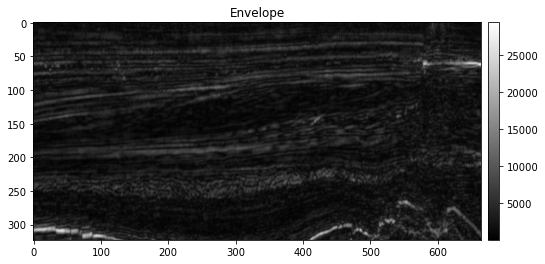

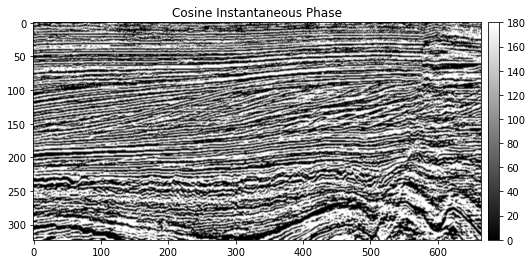

In [10]:
# Change the att list to check the visual difference between various attributes.
# The complete list:
# 'Amplitude', 'Envelope', 'Instantaneous Phase', 'Instantaneous Frequency'
# 'Instantaneous Bandwidth', 'Dominant Frequency', 'Cosine Instantaneous Phase'
# 'Second Derivative', 'Reflection Intensity'

att_list = ['Envelope', 'Cosine Instantaneous Phase']
for att in att_list:
    s_data = slice_data(dataframe[att].values, cube.shape, inline_index)
    plot_slice(s_data, title=att)

## Standard Score Feature Scaling

Attribute values are in different ranges, which may influence in training quality.

It is a good practice in most ML workflows to normalize the example space to accelerate the algorithm convergence. 

We will perform the **standard score** feature scaling [[reference](https://en.wikipedia.org/wiki/Standard_score)] to normalize data and bring it to the center of the distribution:

In [9]:
start_prep_CPU = time.perf_counter()
norm_dataframe = (dataframe - dataframe.mean())/dataframe.std(ddof=0)
total_prep_CPU = time.perf_counter() - start_prep_CPU

print("Data preparation on CPU took {:.2f} seconds.".format(total_prep_CPU))

norm_dataframe.tail()

Data preparation on CPU took 69.99 seconds.


,Amplitude,Envelope,Instantaneous Phase,Instantaneous Frequency,Instantaneous Bandwidth,Dominant Frequency,Cosine Instantaneous Phase,Second Derivative,Reflection Intensity
207572620,-0.554665,0.760718,-1.204019,0.714143,-0.276465,-0.140672,1.770228,0.102894,-0.756378
207572621,0.128993,0.805912,-0.811615,0.970293,-0.375036,-0.122095,1.770228,0.094118,-0.522423
207572622,0.843189,0.792358,-0.348830,1.258679,-0.005690,0.142508,1.770228,-0.418930,0.003177
207572623,0.764196,0.556439,0.211818,1.722450,0.833296,0.979242,-0.229922,-0.384662,0.674598
207572624,-0.062382,0.048069,0.945167,0.761449,0.433284,0.504097,-0.229922,0.382491,1.126714


# CPU Training

We will first train the *k*-means algorithm in **CPU** using the well-known [scikit-learn](https://scikit-learn.org/stable/) toolkit. Scikit-learn provides simple and efficient tools for predictive data analysis, accessible to everybody, and reusable in various contexts.

The **CPU** computing time will be later used to compare with the **RAPIDS GPU** version.

### Slicing The Dataset

The size of the dataset we have for training is given by the number of amplitude voxels times the number attributes we computed to construct each feature vector. For this first **CPU** vs **GPU** benchmark, we slice the full dataset and consider only a fraction of the available examples (randomly selected).

In [10]:
total_examples = len(norm_dataframe)
print("Total dataset lenght: {}".format(total_examples))

Total dataset lenght: 207572625


The whole training set has almost **210 million** examples. Notice that this spatial complexity may explode if we consider more attributes or even neighboring information, i.e., each feature vector may be composed by a central example and its *k* nearest neighbors, in the 3D space.

To make training feasible and interactive for the purpose of this notebook, consider only **1%** of the data (**$\approx$ 2.1M examples**).

In [11]:
examples_frac = 0.01

num_examples = int(total_examples * examples_frac)
sliced_dataframe = norm_dataframe.sample(n=num_examples)
print("Total examples sampled: {}".format(len(sliced_dataframe)))

sliced_dataframe.tail()

Total examples sampled: 2075726


,Amplitude,Envelope,Instantaneous Phase,Instantaneous Frequency,Instantaneous Bandwidth,Dominant Frequency,Cosine Instantaneous Phase,Second Derivative,Reflection Intensity
71745828,-0.028994,-0.223932,0.946172,-0.080753,-0.116264,-0.113185,-0.229922,-0.155449,0.469867
127781663,0.613539,0.510332,-0.387101,0.830728,0.524064,0.601474,1.770228,-0.547020,0.532820
163389424,-0.723645,0.439744,-1.645180,2.126162,-0.077875,0.243681,1.770228,0.987676,0.259414
129140134,0.903045,0.650221,-0.073389,1.095277,0.735434,0.835063,1.770228,-0.409538,0.500771
68537477,0.901009,0.769105,-0.269797,2.042566,2.278799,2.489274,1.770228,-1.448675,-0.379119


#### Sklearn Training

Training *k*-means is easy with the `fit` interface. 
It is necessary to inform the number of desired classes (clusters), fixed seed, and provide a dataset as a Pandas dataframe. 

**Warning**: we are running 3 training cycles and getting the average executing time. This takes approximately **100 seconds** per run on a 64 threads CPU. It may take longer depending upon your setup. If you want to decrease the total CPU training time, please re-visit the previous cells and change the `examples_frac` variable to a value lower than `0.01`, and reduce the `n_runs` in the following cell.

In [12]:
from sklearn.cluster import KMeans as KMeans_CPU

# ------- Train/Fit -------

# Define the total number of classes.
n_clusters = 6
n_runs = 3
total_train_CPU = 0
print("CPU training with {} clusters.".format(n_clusters))
for i in range(n_runs):
    start_train_CPU = time.perf_counter()
    kmeans_CPU_model = KMeans_CPU(n_clusters=n_clusters, random_state=0).fit(sliced_dataframe)
    total_train_CPU += time.perf_counter() - start_train_CPU

average_CPU_time = total_train_CPU / n_runs
    
print("CPU k-means took in average {:.2f} seconds to train with {} clusters.".format(average_CPU_time, n_clusters))

CPU training with 6 clusters.
CPU k-means took in average 114.11 seconds to train with 6 clusters.


### CPU Predict

Given the trained model, we can then perform the inference (or prediction) on the (full) input dataset:

In [13]:
# ------- Inference/Prediction -------

print("CPU prediction with {} clusters".format(n_clusters))

start_pred_CPU = time.perf_counter()
kmeans_CPU_pred = kmeans_CPU_model.predict(dataframe)
total_pred_CPU = time.perf_counter() - start_pred_CPU

print("CPU k-means took {:.2f} seconds to predict with {} clusters.".format(total_pred_CPU, n_clusters))

CPU prediction with 6 clusters
CPU k-means took 14.46 seconds to predict with 6 clusters.


#### Visualizing Predictions 

Let's visualize the prediction result over an inline (`inline_index`):

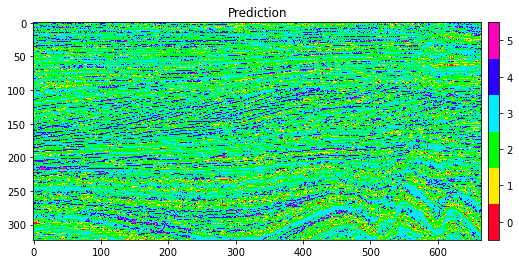

In [19]:
# Change @inline_index if you want to check result for a different inline section.
inline_index = 0

s_data_CPU = slice_data(kmeans_CPU_pred, cube.shape, inline_index)
plot_slice(s_data_CPU, title='Prediction', cmap='gist_rainbow', interpolation=None, is_discrete=True)

# GPU Training

Moving to the **GPU** implementation, we will explore the use of RAPIDS to perform **GPU** accelerated training.

The [RAPIDS](https://rapids.ai/) suite of open-source software libraries gives the freedom to execute end-to-end data science and analytics pipelines entirely on **NVIDIA GPUs**.

Let's check the current **GPU** envinroment.

In [14]:
!nvidia-smi

Mon Sep 14 12:42:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:47:00.0 Off |                    0 |
| N/A   30C    P0    61W / 400W |      0MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:4E:00.0 Off |                    0 |
| N/A   

#### cuDF object

Built based on the Apache Arrow columnar memory format, **cuDF** is a GPU DataFrame library for loading, joining, aggregating, filtering, and otherwise manipulating data [[reference](https://github.com/rapidsai/cudf)]. It is the equivalent of Pandas dataframe, built to run entirely on **GPUs**.

In [15]:
import cudf

In [16]:
cu_dataframe = cudf.DataFrame.from_pandas(dataframe)
cu_dataframe.tail()

,Amplitude,Envelope,Instantaneous Phase,Instantaneous Frequency,Instantaneous Bandwidth,Dominant Frequency,Cosine Instantaneous Phase,Second Derivative,Reflection Intensity
207572620,-1352.0,2474.029053,-123.125656,25.254229,14.943743,29.344360,180.0,154.502228,-4874.5
207572621,327.0,2568.564209,-82.685913,30.601643,5.266693,31.051546,180.0,141.324753,-3341.5
207572622,2081.0,2540.212402,-34.992924,36.622021,41.526726,55.368237,180.0,-629.051208,102.5
207572623,1887.0,2046.723999,22.785507,46.303741,123.892845,132.262894,0.0,-577.595642,4502.0
207572624,-143.0,983.328857,98.361855,26.241787,84.622292,88.597763,0.0,574.336731,7464.5


### GPU Data Preparation

For **GPU** data preparation, it is important to be aware that binary operations (like subtraction) need a temporary buffer to hold the transformed dataframe, even if its *eventually* replace the original one.

Aiming to reduce the memory footprint on **GPU**, consider iterating over each CUDA dataframe column as following:

In [17]:
start_prep_GPU = time.perf_counter()

for col in cu_dataframe.columns:
    cu_dataframe[col] = (cu_dataframe[col] - cu_dataframe[col].mean()) / cu_dataframe[col].std()

total_prep_GPU = time.perf_counter() - start_prep_GPU

print("Data preparation on GPU took {:.2f} seconds.".format(total_prep_GPU))

cu_dataframe.tail()

Data preparation on GPU took 0.78 seconds.


,Amplitude,Envelope,Instantaneous Phase,Instantaneous Frequency,Instantaneous Bandwidth,Dominant Frequency,Cosine Instantaneous Phase,Second Derivative,Reflection Intensity
207572620,-0.554667,-0.144674,-1.204115,-0.761390,-0.879074,-0.948395,1.012306,0.102894,-0.756378
207572621,0.128991,-0.099480,-0.811712,-0.505240,-0.977644,-0.929818,1.012306,0.094118,-0.522423
207572622,0.843187,-0.113034,-0.348927,-0.216854,-0.608298,-0.665214,1.012306,-0.418930,0.003177
207572623,0.764194,-0.348953,0.211721,0.246916,0.230688,0.171519,-0.987844,-0.384662,0.674598
207572624,-0.062384,-0.857323,0.945070,-0.714084,-0.169324,-0.303625,-0.987844,0.382491,1.126714


#### cuML Training

As in the previous CPU example, we will perform 3 training cycles and take the average executing time. 

Notice that the syntax for the **GPU**  version with **cuML** is the *same* as scikit-learn. Changing only the import, we move the training to a scalable high-performance environment with RAPIDS.

In [18]:
from cuml.cluster import KMeans as KMeans_GPU

# Training GPU k-means using the previous sliced dataset.
sliced_cu_dataframe = cudf.DataFrame.from_pandas(sliced_dataframe)

# ------- Train/Fit -------

# Define the total number of classes.
n_clusters = 6
n_runs = 3
total_train_GPU = 0
print("GPU training with {} clusters.".format(n_clusters))
kmeans_GPU_model = None
for i in range(n_runs):
    start_train_GPU = time.perf_counter()
    kmeans_GPU_model = KMeans_GPU(n_clusters=n_clusters, random_state=0).fit(sliced_cu_dataframe)
    total_train_GPU += time.perf_counter() - start_train_GPU

average_GPU_time = total_train_GPU/n_runs

print("GPU k-means took in average {:.2f} seconds to train with {} clusters.".format(average_GPU_time, n_clusters))

GPU training with 6 clusters.
GPU k-means took in average 0.47 seconds to train with 6 clusters.


#### GPU Prediction

To perform prediction on the entire volume, we previously moved the data to the **GPU** via `cudf.DataFrame.from_pandas` API. 

Now we are up to perform inference/prediction with the trained model.

In [19]:
# ------------- Predict -------------

print("GPU prediction with {} clusters.".format(n_clusters))

start_pred_GPU = time.perf_counter()
kmeans_gpu = kmeans_GPU_model.predict(cu_dataframe)
total_pred_GPU = time.perf_counter() - start_pred_GPU

print("GPU k-means took {:.2f} seconds to predict with {} clusters.".format(total_pred_GPU, n_clusters))

GPU prediction with 6 clusters.
GPU k-means took 0.67 seconds to predict with 6 clusters.


#### Visualizing Predictions 

Let's visualize the prediction over a particular slice:

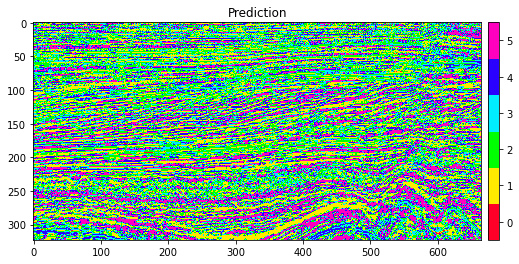

In [26]:
import cupy as cp

s_data_gpu = slice_data(kmeans_gpu.values, cube.shape, inline_index)
s_data_gpu = cp.asnumpy(s_data_gpu)
plot_slice(s_data_gpu, title='Prediction', cmap='gist_rainbow', interpolation=None, is_discrete=True)

#### GPU Speedup

In [20]:
print("GPU data preparation is {:.2f} times faster than CPU!".format(total_prep_CPU/total_prep_GPU))

GPU data preparation is 90.22 times faster than CPU!


In [21]:
print("GPU training is {:.2f} times faster than CPU!".format(average_CPU_time/average_GPU_time))

GPU training is 241.43 times faster than CPU!


In [22]:
print("GPU inference is {:.2f} times faster than CPU!".format(total_pred_CPU/total_pred_GPU))

GPU inference is 21.63 times faster than CPU!


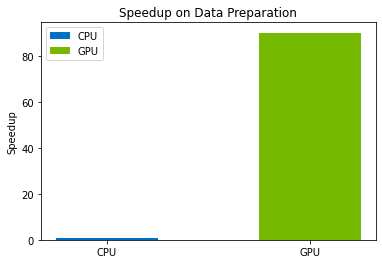

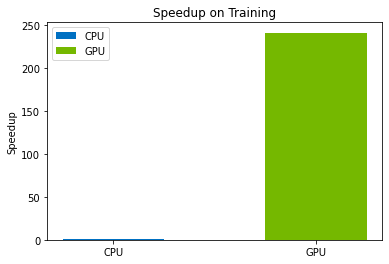

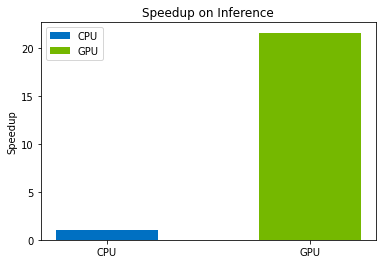

In [2]:
def plot_speedup(gpu_speedup, phase, plot_idx):
    height = [1, gpu_speedup]
    bars = ('CPU', 'GPU')
    y_pos = [0, 0.01]    

    plt.bar(y_pos[0], height[0], width=0.005, color=(0, 0.44, 0.76), label=bars[0])
    plt.bar(y_pos[1], height[1], width=0.005, color=(0.46, 0.72, 0), label=bars[1])

    plt.xticks(y_pos, bars)
    plt.legend(loc='best')
    plt.ylabel('Speedup')
    plt.title('Speedup on ' + phase)
    plt.show()
    
plot_speedup(total_prep_CPU/total_prep_GPU, 'Data Preparation', 1)
plot_speedup(average_CPU_time/average_GPU_time, 'Training', 2)
plot_speedup(total_pred_CPU/total_pred_GPU, 'Inference', 3)

## Multi-GPU Scalability

For the scalability experiment, we move to a distributed environment since the dataset does not fit into a single **GPU**. The memory requirement is $\approx$ **50GB**, plus the internal copies necessary to train the model (about 4x times).

The Dask library is handy in this scenario. [Dask](https://dask.org/) is a flexible library for parallel computing in Python that makes scaling out your workflow smooth and simple. On the CPU, Dask uses Pandas to execute operations in parallel on DataFrame partitions, in **GPU** partitions are processed by cuDF [[reference](https://docs.rapids.ai/api/cudf/stable/10min.html)].

#### When to use cuDF and Dask-cuDF?

If your workflow is fast enough on a single **GPU** or your data comfortably fits in memory on a single **GPU**, you would want to use **cuDF**. If you want to distribute your workflow across multiple **GPUs**, have more data than you can fit in memory on a single **GPU**, or want to analyze data spread across many files at once, you would want to use Dask-cuDF [[reference](https://docs.rapids.ai/api/cudf/stable/10min.html)].

For the following test, it is expected a **GPU** server with **4x GPUs**. Here, we selected and sliced **4x GPUs** from a **[DGX-A100](https://www.nvidia.com/en-us/data-center/dgx-a100/)** system:

In [1]:
!nvidia-smi

Mon Sep 14 14:04:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:47:00.0 Off |                    0 |
| N/A   30C    P0    61W / 400W |      0MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:4E:00.0 Off |                    0 |
| N/A   

In [2]:
import os
import segyio
import numpy as np
import time
import facies_utils

The dataset we use for distributed training is the **Kahu-3D** ([https://wiki.seg.org/wiki/Kahu-3D](https://wiki.seg.org/wiki/Kahu-3D)), which has 6.2 GBytes.
We would like to thank the New Zealand Petroleum and Minerals (NZPM - http://www.nzpam.govt.nz/cms) for providing data.

The data header was also modified such that it could be read by the segyio library. To download it directly to `datasets/input` folder, execute the following line:

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1SOjbUHfz7_SO2vbq7jKdByjiLhK9kTf-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1SOjbUHfz7_SO2vbq7jKdByjiLhK9kTf-" -O datasets/input/Kahu.sgy && rm -rf /tmp/cookies.txt 

In [3]:
%%time
input_file = 'datasets/input/Kahu.sgy'
original_cube = np.array(segyio.tools.cube(input_file))
original_cube = np.ascontiguousarray(original_cube, 'float32')

# Getting part of the dataset.
examples_percent = 0.7
cube = facies_utils.get_sub_cube(original_cube, examples_percent)

CPU times: user 9.96 s, sys: 2.55 s, total: 12.5 s
Wall time: 12.5 s


In [4]:
cube.shape

(417, 1186, 1048)

In [5]:
kahu_dataframe = facies_utils.run_attributes(cube)
kahu_dataframe.tail()

Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.
Invalid number of FFT data points (0) specified.


/tmp/rapids-seismic/d2geo/attributes/util.py:347: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


,Amplitude,Envelope,Instantaneous Phase,Instantaneous Frequency,Instantaneous Bandwidth,Dominant Frequency,Cosine Instantaneous Phase,Second Derivative,Reflection Intensity
518300971,2907.164062,3158.765137,23.022945,16.783007,122.027466,123.176186,0.0,-401.454742,15236.024414
518300972,1652.016357,2395.898682,46.408001,14.794862,115.668457,116.610809,0.0,105.788582,12870.748047
518300973,703.567627,1705.232300,65.632149,15.478421,80.216492,81.696190,0.0,185.714233,9246.273438
518300974,-23.879028,1387.868530,90.985855,27.591272,46.807125,54.334015,0.0,221.028931,5698.165527
518300975,-916.083984,1117.036621,145.095001,18.787901,21.552122,28.591593,0.0,545.388733,3458.815918


In [6]:
import distributed

import dask_cudf
import dask_cuda
import dask.distributed

import cuml.cluster
import cuml.dask.cluster

To perform parallel computations with Dask and RAPIDS [[ref]](https://rapids.ai/dask.html) it is necessary to set up and configure a Dask-cluster and Dask-client. Creating a local cluster `dask_cuda.LocalCUDACluster` with `n_workers=4` will setup **4x GPUs** to distribute computing.

In [7]:
cluster = dask_cuda.LocalCUDACluster(n_workers=4)
cluster

In [8]:
client = dask.distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41111 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 2.16 TB


In [9]:
%%time
# Creating a CUDA distributed dataframe.
cu_ddf = dask_cudf.from_dask_dataframe(kahu_dataframe)

CPU times: user 1.62 s, sys: 599 ms, total: 2.22 s
Wall time: 2.12 s


In [10]:
%%time
cu_ddf = ((cu_ddf - cu_ddf.mean())/cu_ddf.std(ddof=0)).persist()
done = distributed.wait(cu_ddf)

CPU times: user 47.4 s, sys: 21.5 s, total: 1min 8s
Wall time: 8min 48s


In [11]:
cu_ddf.tail()

,Amplitude,Envelope,Instantaneous Phase,Instantaneous Frequency,Instantaneous Bandwidth,Dominant Frequency,Cosine Instantaneous Phase,Second Derivative,Reflection Intensity
518300971,2.141269,1.400264,0.220316,-0.644057,2.781965,2.682203,-0.998647,-0.928304,2.979199
518300972,1.216831,0.746291,0.445318,-0.806168,2.582927,2.456755,-0.998647,0.244620,2.516732
518300973,0.518283,0.154212,0.630286,-0.750431,1.473279,1.257825,-0.998647,0.429437,1.808062
518300974,-0.017494,-0.117850,0.874229,0.237238,0.427563,0.318238,-0.998647,0.511096,1.114323
518300975,-0.674618,-0.350023,1.394846,-0.480580,-0.362920,-0.565729,-0.998647,1.261130,0.676477


**Warning**: the following command is optional. It is used to store attribute in disk for further reuse.

In [12]:
%%time
cu_ddf.to_parquet('datasets/attributes/Kahu_att.parq', key='default')

CPU times: user 2.61 s, sys: 439 ms, total: 3.05 s
Wall time: 30.8 s


Uncomment the following commands if you already have an attribute Parquet attribute file pre-computed.

Notice that `.persist()` in combination with `.wait()` forces dask to solve its lazy representation.

In [ ]:
%%time
#cu_ddf = dask_cudf.read_parquet('datasets/attributes/Kahu_att.parq').persist()
#done = distributed.wait(cu_ddf)

In [13]:
n_clusters=6

print("GPU training with {} clusters.".format(n_clusters))

start_train_gpu = time.perf_counter()
kmeans_gpu = cuml.dask.cluster.KMeans(n_clusters=n_clusters, verbose=True).fit(cu_ddf)
total_train_GPU = time.perf_counter() - start_train_gpu

print("GPU k-means took {:.2f} seconds to train with {} clusters.".format(total_train_GPU, n_clusters))

GPU training with 6 clusters.
GPU k-means took 31.78 seconds to train with 6 clusters.
